# Setup & Config

In [1]:
import os
import sys
import findspark
from tools.config_ip import get_windows_ip, get_wsl_ip

# --- SPARK CONFIG ---
SPARK_PATH = "C:/spark/spark-3.4.1-bin-hadoop3"
JAVA_PATH = "C:/Progra~1/Java/jdk-11"
HADOOP_PATH = "C:/spark/spark-3.4.1-bin-hadoop3/hadoop"

os.environ['SPARK_HOME'] = SPARK_PATH
os.environ['JAVA_HOME'] = JAVA_PATH
os.environ['HADOOP_HOME'] = HADOOP_PATH
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3.10'
os.environ["HADOOP_USER_NAME"] = "ubt_trgmai"

sys.path.insert(0, os.path.join(SPARK_PATH, "python"))
sys.path.insert(0, os.path.join(SPARK_PATH, "python", "lib", "py4j-0.10.9.7-src.zip"))

findspark.init(SPARK_PATH)

from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import col, count, when, isnan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tools.utils import build_pipeline, get_marketing_strategy, save_model_hybrid

# Init Spark
WINDOWS_IP = get_windows_ip()
conf = SparkConf() \
    .setAppName("Customer_Segmentation_Notebook") \
    .setMaster(f"spark://{WINDOWS_IP}:7077") \
    .set("spark.driver.host", WINDOWS_IP) \
    .set("spark.driver.bindAddress", WINDOWS_IP)\
    .set("spark.rpc.message.maxSize", "1024") \
    .set("spark.kryoserializer.buffer.max", "1024m")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
print(f"✅ Spark Connected: {spark.version}")

✅ Spark Connected: 3.4.1


# Load Data

In [2]:
WSL_IP = get_wsl_ip()
hdfs_path = f"hdfs://{WSL_IP}:9000/project/input/Mall_Customers.csv"
print(f"📂 Reading data from: {hdfs_path}")

df = spark.read.csv(hdfs_path, header=True, inferSchema=True)

# Chuẩn hoá tên cột để khớp với utils.py
df = df.withColumnRenamed("Annual Income (k$)", "AnnualIncome") \
       .withColumnRenamed("Spending Score (1-100)", "SpendingScore")

df.show(5)
df.printSchema()

📂 Reading data from: hdfs://172.17.164.83:9000/project/input/Mall_Customers.csv
+----------+------+---+------------+-------------+
|CustomerID|Gender|Age|AnnualIncome|SpendingScore|
+----------+------+---+------------+-------------+
|         1|  Male| 19|          15|           39|
|         2|  Male| 21|          15|           81|
|         3|Female| 20|          16|            6|
|         4|Female| 23|          16|           77|
|         5|Female| 31|          17|           40|
+----------+------+---+------------+-------------+
only showing top 5 rows

root
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- AnnualIncome: integer (nullable = true)
 |-- SpendingScore: integer (nullable = true)



# Khám phá dữ liệu (EDA)

In [3]:
print("=== 1. KIỂM TRA NULL & DUPLICATE ===")
# Check Null
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

# Check Duplicate
total_count = df.count()
distinct_count = df.distinct().count()
print(f"Tổng số dòng: {total_count}")
print(f"Số dòng trùng lặp: {total_count - distinct_count}")

=== 1. KIỂM TRA NULL & DUPLICATE ===
+----------+------+---+------------+-------------+
|CustomerID|Gender|Age|AnnualIncome|SpendingScore|
+----------+------+---+------------+-------------+
|         0|     0|  0|           0|            0|
+----------+------+---+------------+-------------+

Tổng số dòng: 200
Số dòng trùng lặp: 0



=== 2. THỐNG KÊ MÔ TẢ ===
+-------+-----------------+-----------------+------------------+
|summary|              Age|     AnnualIncome|     SpendingScore|
+-------+-----------------+-----------------+------------------+
|  count|              200|              200|               200|
|   mean|            38.85|            60.56|              50.2|
| stddev|13.96900733155888|26.26472116527124|25.823521668370173|
|    min|               18|               15|                 1|
|    max|               70|              137|                99|
+-------+-----------------+-----------------+------------------+


=== 3. TRỰC QUAN HOÁ DỮ LIỆU ===


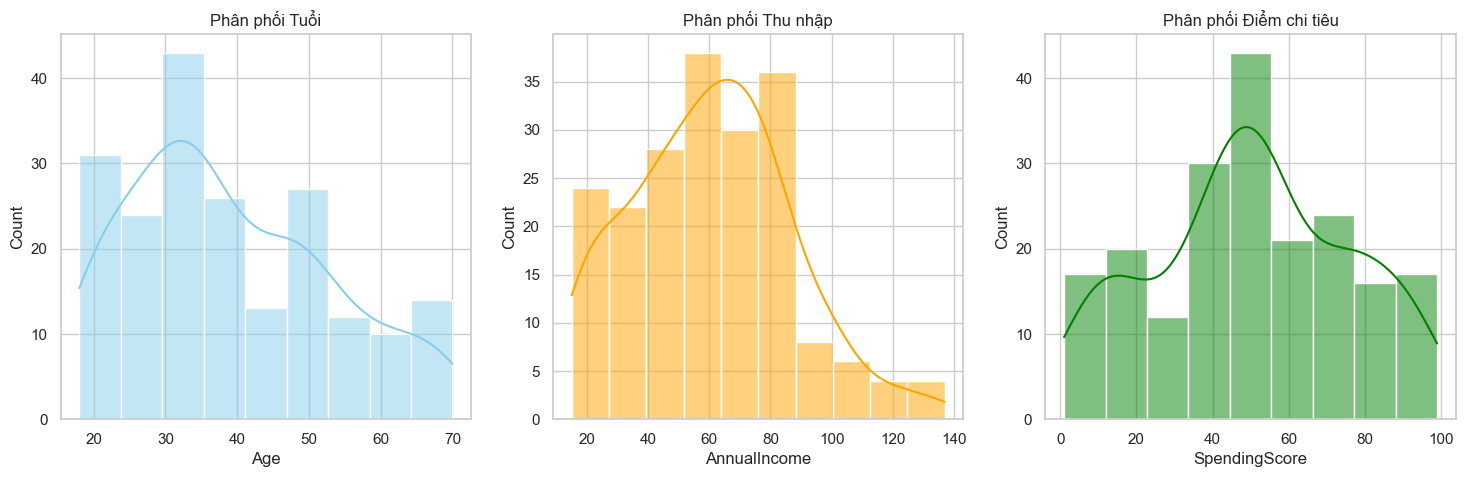

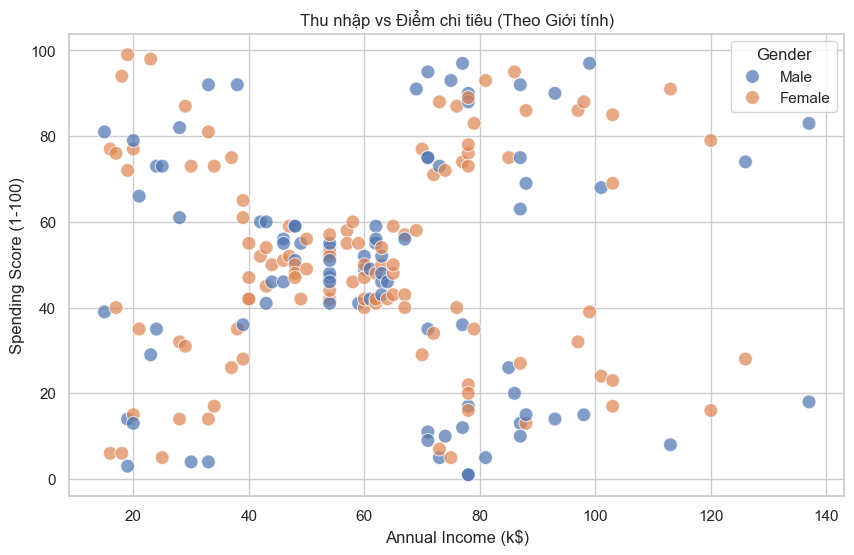

C:\Users\Truong_Mai\AppData\Local\Temp\ipykernel_20552\1968816880.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pdf, x='Gender', palette="pastel")


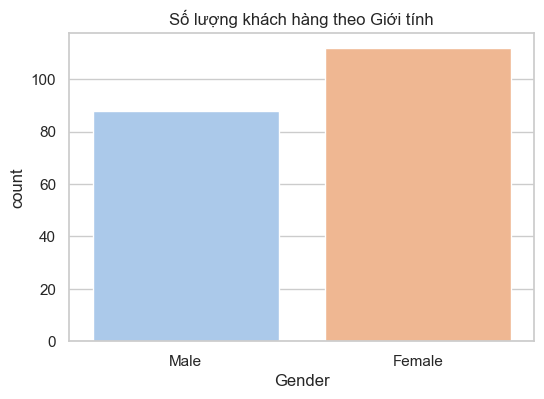

In [4]:
print("\n=== 2. THỐNG KÊ MÔ TẢ ===")
df.select("Age", "AnnualIncome", "SpendingScore").describe().show()

print("\n=== 3. TRỰC QUAN HOÁ DỮ LIỆU ===")
# Chuyển sang Pandas để vẽ biểu đồ
pdf = df.toPandas()

# Set style
sns.set(style="whitegrid")

# 3.1 Distribution Plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(pdf['Age'], kde=True, color='skyblue', ax=ax[0]).set_title('Phân phối Tuổi')
sns.histplot(pdf['AnnualIncome'], kde=True, color='orange', ax=ax[1]).set_title('Phân phối Thu nhập')
sns.histplot(pdf['SpendingScore'], kde=True, color='green', ax=ax[2]).set_title('Phân phối Điểm chi tiêu')
plt.show()

# 3.2 Scatter Plot Income vs Spending
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pdf, x='AnnualIncome', y='SpendingScore', hue='Gender', s=100, alpha=0.7)
plt.title('Thu nhập vs Điểm chi tiêu (Theo Giới tính)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

# 3.3 Gender Count
plt.figure(figsize=(6, 4))
sns.countplot(data=pdf, x='Gender', palette="pastel")
plt.title('Số lượng khách hàng theo Giới tính')
plt.show()

# Chọn K

Đang chạy Elbow Method...
K=2, Cost=269.35
K=3, Cost=156.92
K=4, Cost=122.28
K=5, Cost=65.24
K=6, Cost=55.10
K=7, Cost=44.69
K=8, Cost=41.41
K=9, Cost=34.38
K=10, Cost=36.10


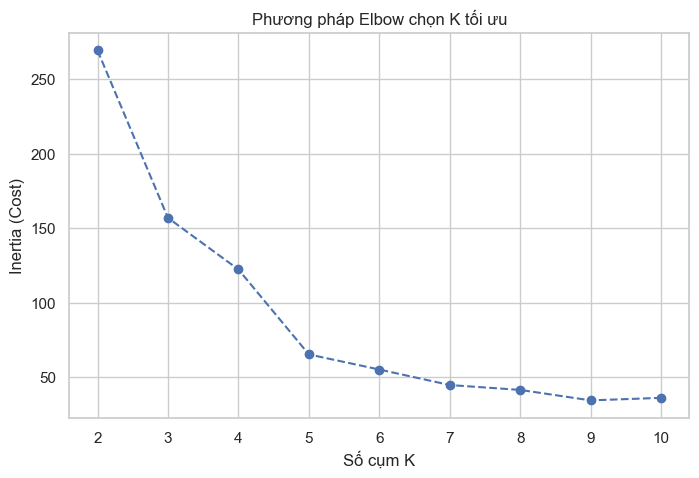

Dựa vào biểu đồ, ta chọn K=5 là điểm gập rõ ràng nhất.


In [5]:
print("Đang chạy Elbow Method...")
costs = []
k_range = range(2, 11)

for k in k_range:
    pipeline = build_pipeline(k)
    model = pipeline.fit(df)
    kmeans_model = model.stages[-1]
    cost = kmeans_model.summary.trainingCost
    costs.append(cost)
    print(f"K={k}, Cost={cost:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(k_range, costs, marker='o', linestyle='--')
plt.xlabel('Số cụm K')
plt.ylabel('Inertia (Cost)')
plt.title('Phương pháp Elbow chọn K tối ưu')
plt.show()

print("Dựa vào biểu đồ, ta chọn K=5 là điểm gập rõ ràng nhất.")

# Huấn luyện & Đánh giá

🚀 Bắt đầu train với K=5
=== PHÂN TÍCH CỤM ===

[Cluster 1] - Tiêu chuẩn (81 khách)
  - Avg Income: 55.3k$ | Avg Score: 49.5
  - Đặc điểm: Khách hàng Trung bình

[Cluster 3] - Rủi ro (22 khách)
  - Avg Income: 25.7k$ | Avg Score: 79.4
  - Đặc điểm: Thu nhập THẤP - Chi tiêu CAO

[Cluster 4] - VIP (39 khách)
  - Avg Income: 86.5k$ | Avg Score: 82.1
  - Đặc điểm: Thu nhập CAO - Chi tiêu CAO

[Cluster 2] - Tiết kiệm (23 khách)
  - Avg Income: 26.3k$ | Avg Score: 20.9
  - Đặc điểm: Thu nhập THẤP - Chi tiêu THẤP

[Cluster 0] - Tiềm năng (35 khách)
  - Avg Income: 88.2k$ | Avg Score: 17.1
  - Đặc điểm: Thu nhập CAO - Chi tiêu THẤP


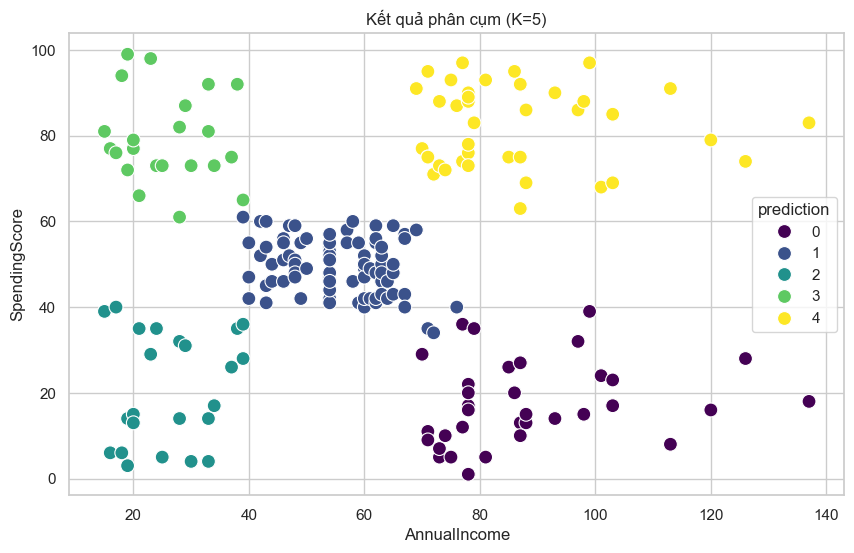

In [6]:
K_OPTIMAL = 5
print(f"🚀 Bắt đầu train với K={K_OPTIMAL}")

pipeline = build_pipeline(K_OPTIMAL)
final_model = pipeline.fit(df)
predictions = final_model.transform(df)

# Thống kê từng cụm
print("=== PHÂN TÍCH CỤM ===")
cluster_stats = predictions.groupBy("prediction").agg({
    "AnnualIncome": "mean",
    "SpendingScore": "mean",
    "Age": "count"
}).collect()

# Hiển thị ý nghĩa
for row in cluster_stats:
    cid = row['prediction']
    inc = row['avg(AnnualIncome)']
    score = row['avg(SpendingScore)']
    count_mem = row['count(Age)']
    
    name, desc, action = get_marketing_strategy(inc, score)
    print(f"\n[Cluster {cid}] - {name} ({count_mem} khách)")
    print(f"  - Avg Income: {inc:.1f}k$ | Avg Score: {score:.1f}")
    print(f"  - Đặc điểm: {desc}")

# Visualize kết quả phân cụm
res_pdf = predictions.select("AnnualIncome", "SpendingScore", "prediction").toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=res_pdf, x='AnnualIncome', y='SpendingScore', hue='prediction', palette='viridis', s=100)
plt.title(f'Kết quả phân cụm (K={K_OPTIMAL})')
plt.show()

# Lưu Model

In [7]:
save_path = save_model_hybrid(final_model, f"notebook_model_k{K_OPTIMAL}", K_OPTIMAL, "notebook")

print(f"✅ QUY TRÌNH HOÀN TẤT!")
print(f"👉 Model đã lưu an toàn trên HDFS.")
print(f"👉 Bản sao đã được tải về: {save_path}")

🔎 Detected HDFS Path: /home/ubt_trgmai/hadoop/bin/hdfs
🔄 [1/3] Saving to HDFS: hdfs://172.17.164.83:9000/project/models/notebook_model_k5...
🔄 [2/3] Syncing to Local Windows: c:\Users\Truong_Mai\Documents\IE405.F11.CN2.CNTT\models\notebook_model_k5...
✅ Sync Local thành công!
✅ QUY TRÌNH HOÀN TẤT!
👉 Model đã lưu an toàn trên HDFS.
👉 Bản sao đã được tải về: c:\Users\Truong_Mai\Documents\IE405.F11.CN2.CNTT\models\notebook_model_k5


In [8]:
spark.stop()